In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
%matplotlib inline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
os.listdir('./data')

['test.csv', 'train.csv', 'gender_submission.csv']

In [3]:
df_test = pd.read_csv('./data/test.csv')
df_train = pd.read_csv('./data/train.csv')
df_submission = pd.read_csv('./data/gender_submission.csv')

In [4]:
y_train_val = df_train.Survived

In [5]:
def transform(df,option):
    assert option in ["test","train"] , "Option must be test or train"
    df = df.set_index('PassengerId')
    cond = df.Fare.isnull()
    sub_value = df.Fare.mean()
    df.Fare = np.where(cond, sub_value, df.Fare)
    ticket_p = df.groupby('Ticket', as_index=False).agg({'Name': 'count'}).rename(columns={'Name':'t_count'}).sort_values('t_count', ascending=False)
    d = dict()
    for i, row in ticket_p.iterrows():
        d[row.Ticket] = row.t_count
    df_merge = df.copy()
    df_merge['t_count'] = df_merge.Ticket.apply(lambda x: d[x])
    df_merge['Fare_per_person'] = df_merge.Fare/df_merge.t_count
    cond = df_merge.Age.isnull()
    sub_value = df_merge.Age.mean()
    df_merge.Age = np.where(cond, sub_value, df_merge.Age)
    cond = (df_merge.Sex == 'female')
    sub_value = 1
    df_merge.Sex = np.where(cond, sub_value, 0)
    cond = df_merge.Embarked.isnull()
    sub_value = 'S'
    df_merge.Embarked = np.where(cond, 'S', df_merge.Embarked)
    df_merge = df_merge.drop(['Name', 'Ticket', 'Cabin'], axis=1)
    df_merge.isnull().sum()
    ohe = OneHotEncoder()
    X_cat = ohe.fit_transform(df_merge.Embarked.values.reshape(-1,1)).toarray()
    if option=="train":
        X_short = df_merge.drop(['Survived','Embarked'], axis=1).values
    else:
        X_short = df_merge.drop(['Embarked'], axis=1).values
    X = np.hstack([X_cat, X_short])
    return X

In [6]:
X_train_val=transform(df_train, "train")

In [7]:
X_test=transform(df_test,"test")

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [9]:
X_train.shape, X_val.shape

((712, 11), (179, 11))

In [10]:
lr=LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
y_pred_val=lr.predict(X_val)
acc_val=accuracy_score(y_val,y_pred_val)
acc_val

0.8156424581005587

In [11]:
C_grid=np.logspace(-4,9,9)
C_grid

array([1.00000000e-04, 4.21696503e-03, 1.77827941e-01, 7.49894209e+00,
       3.16227766e+02, 1.33352143e+04, 5.62341325e+05, 2.37137371e+07,
       1.00000000e+09])

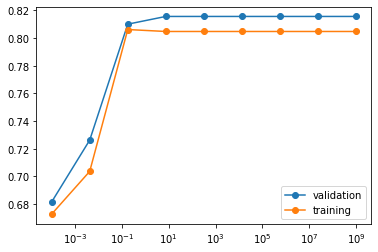

In [17]:
acc_vals=[]
acc_trains=[]
for c in C_grid:
    lr1=LogisticRegression(C=c,max_iter=500)
    lr1.fit(X_train, y_train)
    y_pred_val=lr1.predict(X_val)
    y_pred_train=lr1.predict(X_train)
    acc_train=accuracy_score(y_train,y_pred_train)
    acc_val=accuracy_score(y_val,y_pred_val)
    acc_vals.append(acc_val)
    acc_trains.append(acc_train)

plt.plot(C_grid,acc_vals,'-o', label='validation')
plt.xscale('log')
plt.plot(C_grid,acc_trains,'-o', label='training')
plt.legend()

